# G$^2$Pnet: The Grassmanian Gaussian Process Network
We check the implementation of G2PnetSolver (ver 3.) class in ../src/

Created by Tianpei Xie, 03/31/2016

Last Edit 03/31/2016

In [1]:
%reset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
import GPy
import GPy.util as gutil

%matplotlib inline 
plt.close('all')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
Ifsavefig =  False
Ifsavedata = False

The network generating

In [3]:
size = 40
color_map = {0:'r', 1:'c', 2:'y'}
#center = np.zeros(2)
#center[1] = 1
center = None

n = 40
m = 0
G0= nx.barbell_graph(n,m) 
#generate the bar-bell graph, which consists of two fully connected component and a path connecting them 

label0 = np.zeros([2*n,1])
label0[n:2*n] = np.ones([n,1])
#### labeling of the cluster
for node in G0.nodes():
    G0.node[node]['category'] = int(label0[node,0])

In [4]:
####generate the eigenspace of normalized Laplacian
k = 3
nnodes = nx.adjacency_matrix(G0).shape[0]

ncv=max(2*k+1,int(np.sqrt(nnodes)))

eigenvalues,eigenvectors= sp.sparse.linalg.eigsh(nx.laplacian_matrix(G0).asfptype(), k=k, \
                                                which='SM', return_eigenvectors = True, ncv=ncv)
index=np.argsort(eigenvalues)[1:k] # 0 index is zero eigenvalue    
pos_spectral_mat = np.real(eigenvectors[:,index]) #pos_spectral_mat is the spectral location of the nodes
pos_spectral_df = pd.DataFrame(data=pos_spectral_mat, columns=['PX','PY'], dtype=float)
pos_spectral_df['LABEL'] = label0

The node attributes generating

In [5]:
T= 2
c = 2*np.pi*0.8
data_np = np.zeros([nnodes, T])
column_name = []
for t in np.arange(1,T+1):
    temp1 = np.multiply(pos_spectral_df['PX'].apply(lambda x: np.exp(-c*t*x)).values, \
                          pos_spectral_df['PY'].apply(lambda y: np.cos(c*t*y)).values)
    data_np[:,t-1] = temp1
    if t == 1:
        column_name = str(t-1)+"_cos"
    else:    
        column_name = [column_name, str(t-1)+"_cos"]

sigma = 0.1        
data_np = np.add(data_np, sigma*np.random.randn(nnodes, T))    
data_df = pd.DataFrame(data=data_np, columns=column_name, dtype=float)
data_df['LABEL'] = label0

In [6]:
if Ifsavedata:
    nx.write_adjlist(G0, "../data/experiment_03_31_2016.adjlist",delimiter=',')
    nx.write_edgelist(G0, "../data/experiment_03_31_2016.edgelist")

    np.savez("../data/experiment_data_03_31_2016.npz", pos_spectral_mat, data_np, label0)
    data_df.to_csv("../data/experiment_X_03_31_2016.csv", index_label= 'ID')
    pos_spectral_df.to_csv("../data/experiment_U_03_31_2016.csv", index_label= 'ID')

if Ifsavedata:
    nx.write_adjlist(G0, "../data/experiment_bad_03_31_2016.adjlist",delimiter=',')
    nx.write_edgelist(G0, "../data/experiment_bad_03_31_2016.edgelist")

    np.savez("../data/experiment_bad_data_03_31_2016.npz", pos_spectral_mat, data_np, label0)
    data_df.to_csv("../data/experiment_bad_X_03_31_2016.csv", index_label= 'ID')
    pos_spectral_df.to_csv("../data/experiment_bad_U_03_31_2016.csv", index_label= 'ID')

In [7]:
X= data_np
U= pos_spectral_mat
nsample, ndim = X.shape
_ , ndim_latent = U.shape

kern = GPy.kern.RBF(2) 

Import from the G2PnetSolver_v1.py 

In [8]:
import sys
import os
dirorg = os.path.dirname(os.getcwd())
sys.path.insert(0, dirorg+"/src/")

In [9]:
import G2PnetSolver_v3 #G2PnetSolver_v2
#from imp import reload
#reload(G2PnetSolver_v2)

In [10]:
from G2PnetSolver_v3 import  G2PnetSolver as Solver
from G2PnetSolver_v3 import  Grassmann_update

In [11]:
choice = "near"

In [12]:
np.random.seed(seed=121)

if choice == "random":
    print("Random Initialization")
    Temp = np.random.rand(nsample, nsample)
    Temp_sym = (Temp + Temp.T) / 2 
    _, U_temp = np.linalg.eig(Temp_sym)
    U_test = U_temp[:, np.arange(ndim_latent)]
    U0 = U_test
elif choice == "near":
    print("Initialization in neigborhood.")
    U0 = U

eta0 = 1
G_temp = np.random.rand(nsample, ndim_latent)
H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(U0)),G_temp)
U_init = Grassmann_update(U0, H_temp, eta=eta0)

Initialization in neigborhood.


### Compute the gradient $\frac{dL}{dU}$
The loss function is given as negative log-likelihood of Gaussian process

\begin{align}
\mathcal{L}(\beta, \sigma, \mathbf{U}) &= \frac{pN}{2}\log(2\pi)+\frac{p}{2}\log\det(\mathbf{K}_{\beta, \sigma, \mathbf{U}})+\frac{1}{2}\text{tr}\left(\mathbf{K}_{\beta, \sigma, \mathbf{U}}^{−1}\mathbf{X}\mathbf{X}^T\right) + \frac{\lambda}{2} \|\mathbf{U}\mathbf{U}^{T} -  \mathbf{U}_{L}\mathbf{U}_{L}^{T}\|_{F}^{2}
\end{align}
The partial differential of $\mathcal{L}$ with respect to $\mathbf{K}$
\begin{align}
\mathbf{T}&= 2\mathbf{T}_{0} - \text{diag}\left(\mathbf{T}_{0}\right),\\
\mathbf{T}_{0} &= \frac{1}{2}\left(\mathbf{I} - \mathbf{K}_{\beta, \sigma, \mathbf{U}}^{-1}\mathbf{X}\mathbf{X}^T/p \right)\mathbf{K}_{\beta, \sigma, \mathbf{U}}^{-1}, \\
\mathbf{K}_{r,s} &= K_{\sigma}\left(\mathbf{U}_{r,:} , \mathbf{U}_{s,:}\right) + \beta \delta_{r,s}
\end{align}

For rbf kernel, 
\begin{align}
\frac{\partial \mathbf{K}_{\beta, \sigma, \mathbf{Z}}}{\partial \mathbf{U}_{m,j}} 
&= -\frac{l^{2}}{\sigma^2} \exp\left(-\frac{1}{2\sigma^2} \|\mathbf{U}_{m} -  \mathbf{U}_{n}\|^{2} \right)\left[2\left( \mathbf{U}_{m,i} - \mathbf{U}_{n,j} \right)\right]
\end{align}

The differential of the second norm term 
\begin{align}
\frac{d}{d\mathbf{U}}\frac{1}{2}\|\mathbf{U} \mathbf{U}^{T} -  \mathbf{U}_{L}\mathbf{U}_{L}^{T}\|_{F}^{2} &=
\frac{d}{d\mathbf{U}}\frac{1}{2}\left[\text{tr}\left(\mathbf{U} \mathbf{U}^{T}\right) - \text{tr}\left(\mathbf{U}_{L}\mathbf{U}_{L}^{T}\mathbf{U}\mathbf{U}^{T}\right)\right]\\
&= \left(\mathbf{I} - \mathbf{U}_{L}\mathbf{U}_{L}^{T}\right)\mathbf{U}
\end{align}

The partial differential of $\mathcal{L}$ with respect to $\mathbf{U}$
\begin{align}
\frac{\partial\mathcal{L}}{\partial\mathbf{U}} &= \left[\text{tr}\left( \mathbf{T} \frac{\partial \mathbf{K}_{\beta, \sigma, \mathbf{U}}}{\partial \mathbf{U}_{m,j}} \right)\right]_{m,j} + \lambda \left(\mathbf{I} - \mathbf{U}_{L}\mathbf{U}_{L}^{T}\right)\mathbf{U},
\end{align}

In [13]:
if Ifsavedata:
    U_columns = [str(i) for i in np.arange(ndim_latent)]
    U_df = pd.DataFrame(data = U_init, columns=U_columns, dtype= float)
    if choice == "random":
        U_df['RANDOM'] = np.ones([nsample, 1])
    elif choice == "near":
        U_df['RANDOM'] = np.zeros([nsample, 1])
    
    U_df.to_csv("../data/U_init_03_31_16.csv")
    #U_df.to_csv("../data/U_init_bad_03_31_16.csv")

In [14]:
add_reg = True
lambda_array = np.array([10, 1, 0.001])
eta = 0.001
max_iters = 800
kern_array = [GPy.kern.RBF(2) for i in np.arange(len(lambda_array))]
kern_grass_array = [GPy.kern.RBF(2) for i in np.arange(len(lambda_array))]
solver_array = []
hist_nll_eu_array = []
hist_nll_grass_array = []

In [15]:
trail = 1

kernel initialization ...
negative log-likelihood compute
[step   0] neg-log-likelihood -1120.837009 stepsize 0.001
The gradient of L w.r.t. U not been computed. Just compute it anyway.
The gradient of L w.r.t K not been computed. Just compute it anyway.
The gradient of K w.r.t. U not been computed. Just compute it anyway
[step   1] neg-log-likelihood -1207.546657 stepsize 0.001
[step   2] neg-log-likelihood -1208.083620 stepsize 0.001
[step   3] neg-log-likelihood -1164.531771 stepsize 0.001
[step   4] neg-log-likelihood -1005.675729 stepsize 0.001
[step   5] neg-log-likelihood -704.664923 stepsize 0.001
[step   6] neg-log-likelihood -872.849588 stepsize 0.001
[step   7] neg-log-likelihood -1125.945923 stepsize 0.001
[step   8] neg-log-likelihood -1140.295216 stepsize 0.001
[step   9] neg-log-likelihood -1219.407136 stepsize 0.001
[step  10] neg-log-likelihood -1252.862624 stepsize 0.001
[step  11] neg-log-likelihood -1277.530799 stepsize 0.001
[step  12] neg-log-likelihood -1275.4451

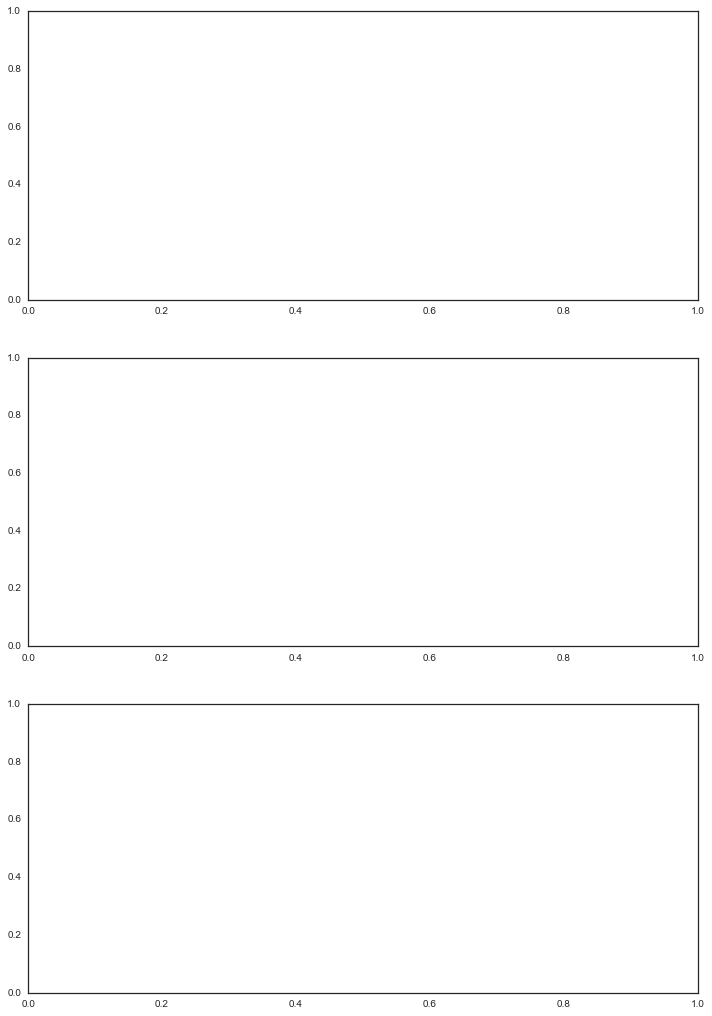

In [16]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 30.0)
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(lambda_array): 
    ax = plt.subplot(5,1,i+1)
    solver = Solver(X=X, U=U_init, kernel=kern_array[i], U_ref= U, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_eu, hist_eta, hist_kern_eu = solver.optimize(max_iters = max_iters)
    solver_array.append(solver)
    hist_nll_eu_array.append(hist_nll_eu)
    
    solver2 = Solver(X=X, U=U_init, kernel=kern_grass_array[i], U_ref = U, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_grass, hist_eta, hist_kern_grass = solver2.optimize(max_iters = max_iters, optimizor = "grad_descent_grass")
    
    solver_array.append(solver2)
    hist_nll_grass_array.append(hist_nll_grass)
        
    %xdel solver
    %xdel solver2

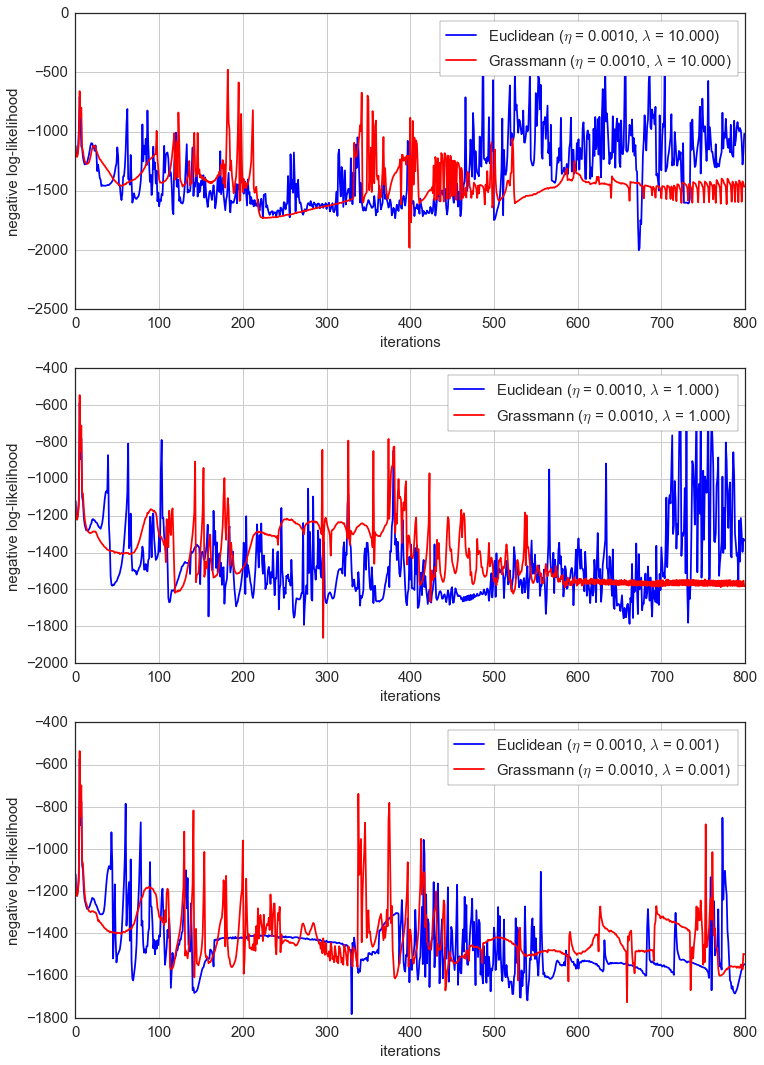

In [17]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_nll_eu_array[i], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_nll_grass_array[i], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"Euclidean ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                             r"Grassmann ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper right', frameon=True)
    else:    
        ax.legend([h1, h2], [r"Euclidean ($\eta$ = {0:5.4f})".format(eta), r"Grassmann ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper right', frameon=True)
    plt.grid(1)
    plt.ylabel('negative log-likelihood', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/nll_iters_Grass_Eu_" + str(trail) + "_"
    file_tail = "_03_31_16.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

These plots show the comparison of learning trajectories for different regularization paramters $\lambda$. We see that the larger $\lambda$, the smoother the curve is. However, it introduces more biases.
<img src="../figures/nll_iters_Grass_Eu_1_nearReg_03_31_16.png">